## MNE Classification of 2 Class

- Preprocessing
- Feature Extraction
- Classification

link to dataset: https://ieee-dataport.org/documents/upper-limb-rehabilitation-motor-imagery-eeg-signals

- EEG Placement 10-20 electrode system

- Notch filter 50 hz applied

- 8th order chebyshev bandpass filter 0.01 hz - 200hz appiled

- Sampling rate 500 Hz

In [86]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert
import re
import mne
from mne import concatenate_epochs
from mne.preprocessing import ICA
from mne_icalabel import label_components
import onnxruntime
import torch
import seaborn as sns
import pandas as pd

from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize

#### Step 1: READ Dataset 

- read all subjects

In [2]:
DataFolder = 'G:\\KMUTT\\Y3_Term2\\Studio_OpenTopic\\StudioV_opentopics\\Dataset_used'

In [3]:
subjects = [1, 2, 3, 4, 5, 6]

# Label 6 classes
label_map = {
    'forearm supination': 0,
    'forearm pronation': 1,
    'shoulder adduction': 2,
    'shoulder abduction': 3,
    'elbow extension': 4,
    'elbow flexion': 5
}

# Helper สำหรับเรียง Run
def extract_run_num(name):
    match = re.search(r'R(\d+)', name)
    return int(match.group(1)) if match else 0

# เตรียมเก็บข้อมูล
EpochList = []
y_all = []

# Load ทุก Subject และ Run
for s in subjects:
    for file_name in sorted(os.listdir(DataFolder), key=extract_run_num):
        if file_name.startswith(f"S{s}R") and file_name.endswith(".set"):
            path = os.path.join(DataFolder, file_name)
            print(f"Reading {file_name}...")

            try:
                # Load .set
                epochs = mne.io.read_epochs_eeglab(path, verbose='ERROR')

                #  สร้าง mapping ชื่อ event เดิม (เช่น S1R1_elbow flexion)
                id_to_name = {v: k for k, v in epochs.event_id.items()}

                #  รีแมพทุก event ใหม่ให้ match กับ label_map
                new_events = []
                selected_labels = []

                for i, (onset, _, eid) in enumerate(epochs.events):
                    event_name = id_to_name[eid].split('_')[-1]
                    if event_name in label_map:
                        new_eid = label_map[event_name]
                        new_events.append([onset, 0, new_eid])
                        selected_labels.append(new_eid)

                if new_events:
                    # 📎 สร้าง Epochs ใหม่ด้วย event ที่รีแมพแล้ว
                    new_events = np.array(new_events)
                    epochs.events = new_events
                    epochs.event_id = label_map.copy()

                    # เฉพาะ epoch ที่เราใช้จริง
                    EpochList.append(epochs)
                    y_all.extend(selected_labels)

            except Exception as e:
                print(f"❌ Failed to load {file_name}: {e}")

# รวมเป็นก้อนเดียวแบบปลอดภัย
combined_epochs = concatenate_epochs(EpochList)
X_all = combined_epochs.get_data()
y_all = np.array(y_all)

# สรุป
print("\n รวมข้อมูลเสร็จแล้ว:")
print(" X shape:", X_all.shape)         # (n_epochs, n_channels, n_times)
print(" y shape:", y_all.shape)         # (n_epochs,)
print(" Label counts (0–5):", np.bincount(y_all))


Reading S1R1.set...
Reading S1R2.set...
Reading S1R3.set...
Reading S1R4.set...
Reading S1R5.set...
Reading S1R6.set...
Reading S1R7.set...
Reading S1R8.set...
Reading S1R9.set...
Reading S1R10.set...
Reading S2R1.set...
Reading S2R2.set...
Reading S2R3.set...
Reading S2R4.set...
Reading S2R5.set...
Reading S2R6.set...
Reading S2R7.set...
Reading S2R8.set...
Reading S2R9.set...
Reading S2R10.set...
Reading S3R1.set...
Reading S3R2.set...
Reading S3R3.set...
Reading S3R4.set...
Reading S3R5.set...
Reading S3R6.set...
Reading S3R7.set...
Reading S3R8.set...
Reading S3R9.set...
Reading S3R10.set...
Reading S4R1.set...
Reading S4R2.set...
Reading S4R3.set...
Reading S4R4.set...
Reading S4R5.set...
Reading S4R6.set...
Reading S4R7.set...
Reading S4R8.set...
Reading S4R9.set...
Reading S4R10.set...
Reading S5R1.set...
Reading S5R2.set...
Reading S5R3.set...
Reading S5R4.set...
Reading S5R5.set...
Reading S5R6.set...
Reading S5R7.set...
Reading S5R8.set...
Reading S5R9.set...
Reading S5R10.se

#### Test Combined epochs

In [4]:
combined_epochs

<EpochsArray | 10800 events (all good), -1 – 1.998 s (baseline off), ~1.93 GiB, data loaded,
 'forearm supination': 1800
 'forearm pronation': 1800
 'shoulder adduction': 1800
 'shoulder abduction': 1800
 'elbow extension': 1800
 'elbow flexion': 1800>

#### Step 2: Bandpass filter

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.5s
[Parallel(n_job

Using matplotlib as 2D backend.


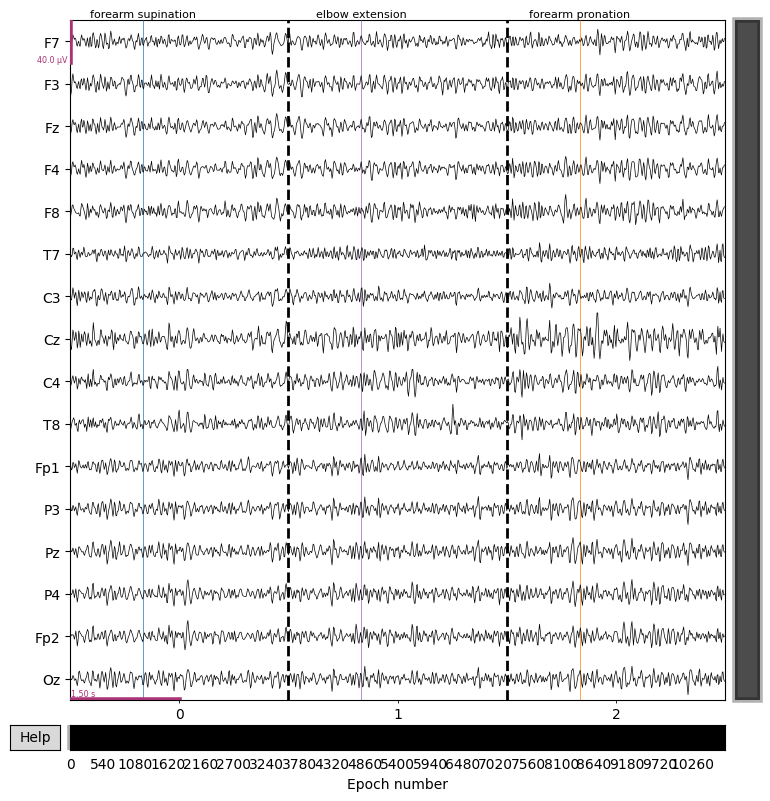

In [5]:
#copy old dataset
combined_copy = combined_epochs.copy()

#Apply bandpass
filtered_epochs = combined_copy.filter(l_freq=8.0, h_freq=30.0)

figfilter = filtered_epochs.plot(n_epochs=3, events=True, event_id=True)

#### Check BandPass

In [6]:
print("High-pass:", filtered_epochs.info['highpass'])
print("Low-pass :", filtered_epochs.info['lowpass'])

High-pass: 8.0
Low-pass : 30.0


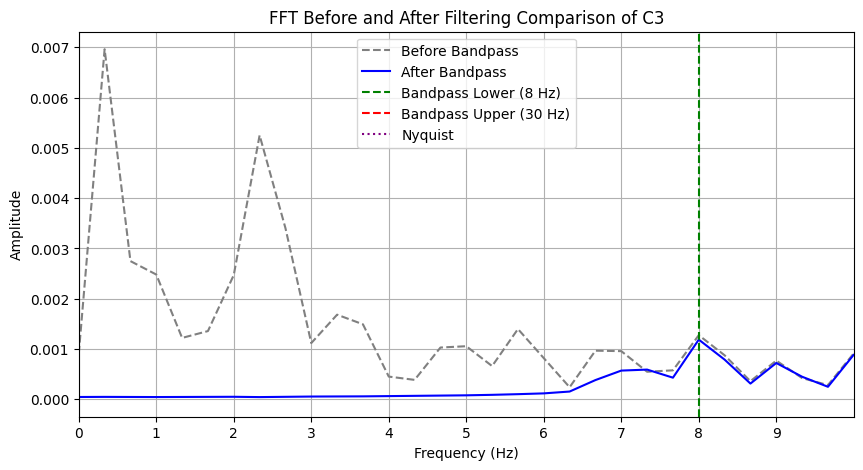

In [7]:
#Plot fft
channel_nam = 'C3'
channel_id = combined_epochs.ch_names.index(channel_nam)  # ก่อน filter
fis = combined_epochs.info['sfreq']

# สัญญาณก่อน filter
signal_before = combined_epochs.get_data()[0, channel_id, :]
# สัญญาณหลัง filter
signal_after = filtered_epochs.get_data()[0, channel_id, :]

# FFT
nu = len(signal_after)
freqs = np.fft.rfftfreq(nu, 1/fis)
fft_before = np.abs(np.fft.rfft(signal_before))
fft_after = np.abs(np.fft.rfft(signal_after))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_before, label="Before Bandpass", color='gray', linestyle='--')
plt.plot(freqs, fft_after, label="After Bandpass", color='blue')
plt.axvline(8, color='green', linestyle='--', label='Bandpass Lower (8 Hz)')
plt.axvline(30, color='red', linestyle='--', label='Bandpass Upper (30 Hz)')
plt.axvline(fis/2, color='purple', linestyle=':', label='Nyquist')

plt.title(f"FFT Before and After Filtering Comparison of {channel_nam}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
# plt.xlim(0, fs / 2)
# plt.ylim(0, 0.0015)  
plt.xlim(0,10)
plt.xticks(np.arange(0, 10, 1))  # ticks each 1 Hz
# plt.ylim(0,0.005)
# plt.yticks(np.arange(0, 0.005, 0.001))  # ticks each 1 Hz
plt.show()


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


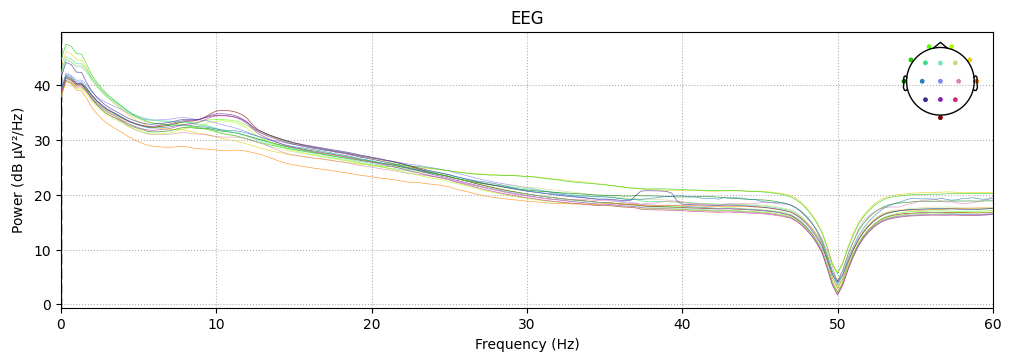

In [8]:
#Plot power Before 
combined_epochs.compute_psd(fmax=60).plot(picks=combined_epochs.ch_names)
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


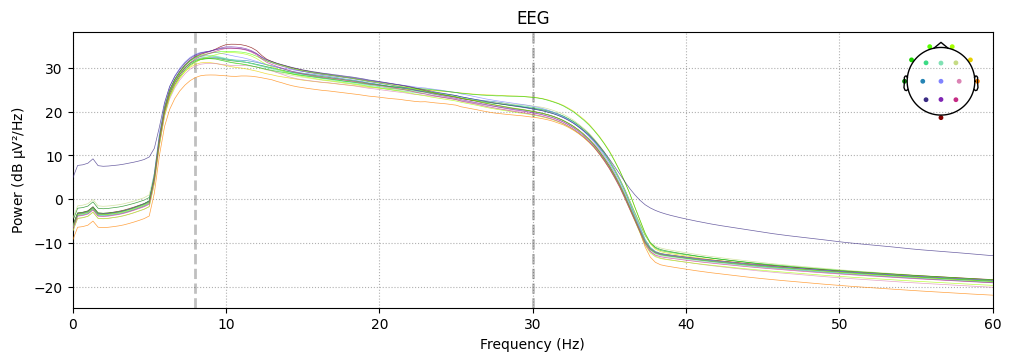

In [9]:
#Plot power After
filtered_epochs.compute_psd(fmax=60).plot(picks=filtered_epochs.ch_names)
plt.show()

#### Step 3: DownSampling

In [10]:
downsampled_epochs = filtered_epochs.copy().resample(128)#128 100
downsampled_epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, Fp1, P3, Pz, P4, Fp2, Oz
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 128.0 Hz
>

#### Check DownSampling

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


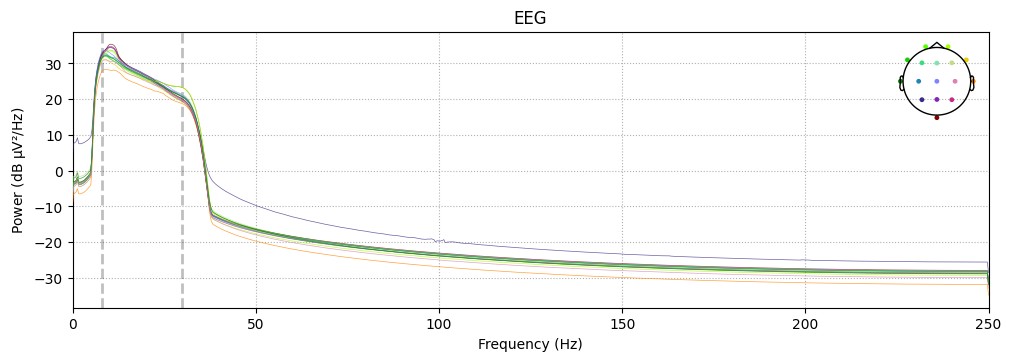

In [11]:
#Plot power Before
filtered_epochs.compute_psd(fmax=250).plot(picks=filtered_epochs.ch_names)
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


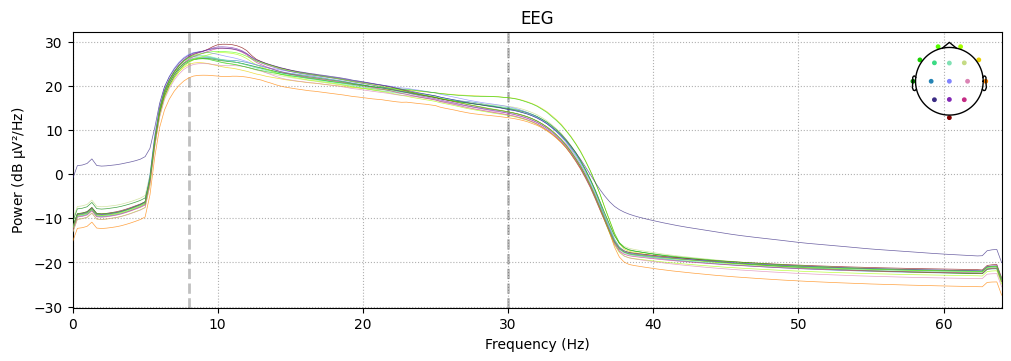

In [12]:
#Plot power After 
downsampled_epochs.compute_psd(fmax=64).plot(picks=downsampled_epochs.ch_names)
plt.show()

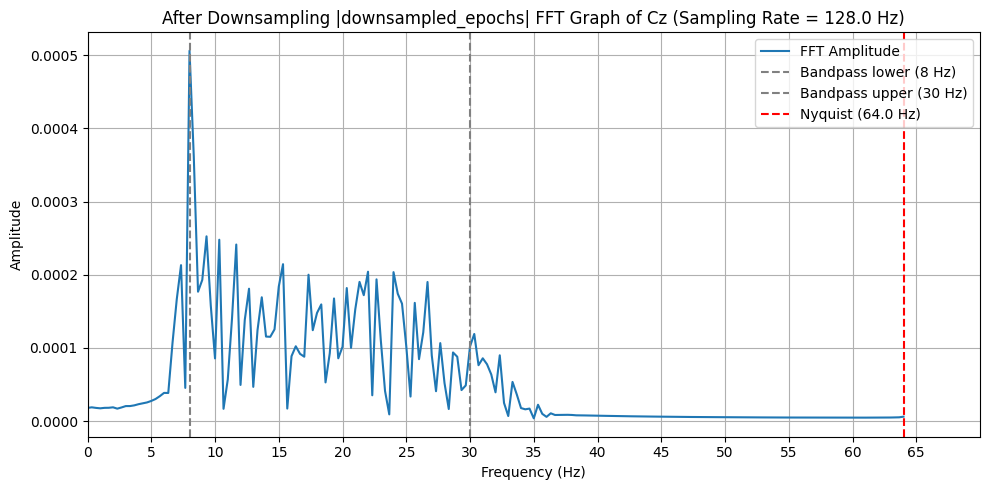

In [13]:
#FFT method after

# Pick channel
chan_name = 'Cz'
chan_index = downsampled_epochs.ch_names.index(chan_name)

# Get signal
s = downsampled_epochs.get_data()[0, chan_index, :]
fs = downsampled_epochs.info['sfreq']

# FFT
n = len(s)
freqs = np.fft.rfftfreq(n, 1/fs)
fft_vals = np.abs(np.fft.rfft(s))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_vals, label='FFT Amplitude')
plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
plt.axvline(fs/2, color='red', linestyle='--', label=f'Nyquist ({fs/2:.1f} Hz)')
plt.title(f"After Downsampling |downsampled_epochs| FFT Graph of {chan_name} (Sampling Rate = {fs} Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.xlim(0, fs / 2)
plt.xlim(0,70)
plt.xticks(np.arange(0, 70, 5))  # ticks each 1 Hz
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Step 4: ICA

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 65.7s.


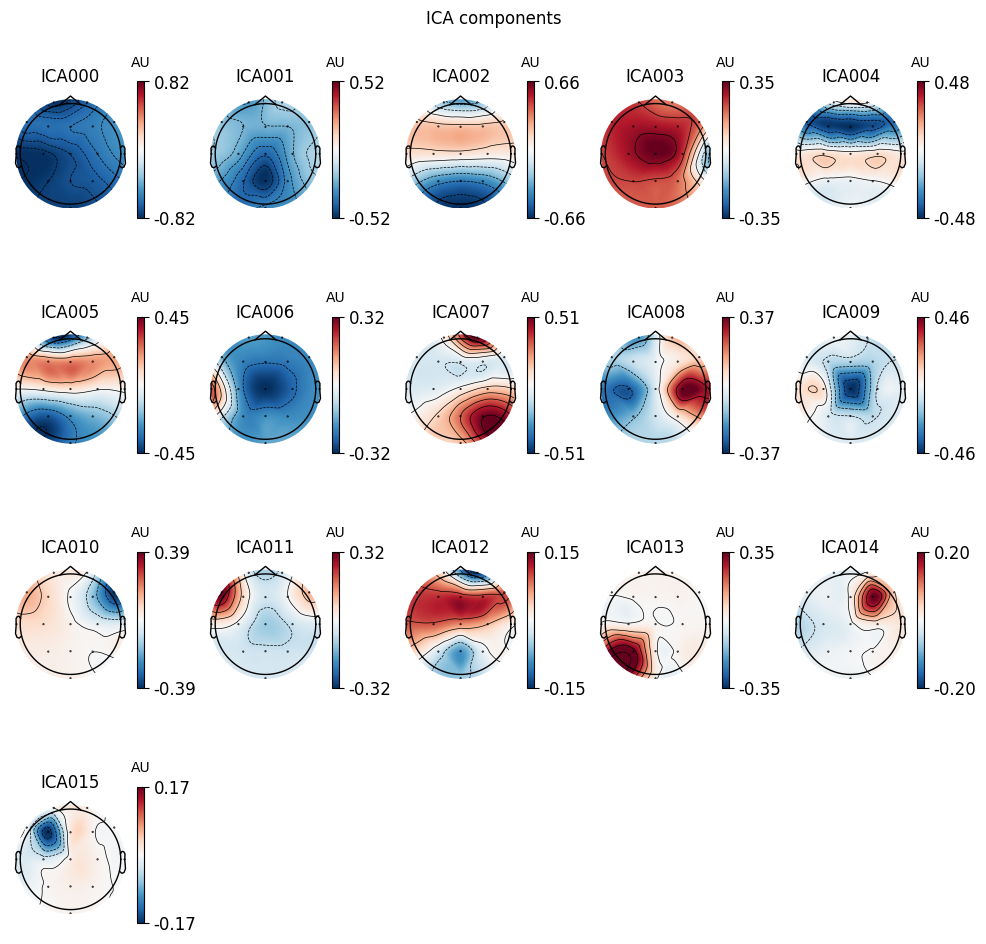

C:\Users\HP\AppData\Local\Temp\ipykernel_24016\673093396.py:14: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_24016\673093396.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_24016\673093396.py:14: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the e

Component 0: heart beat
Component 1: heart beat
Component 2: brain
Component 3: brain
Component 4: brain
Component 5: brain
Component 6: brain
Component 7: brain
Component 8: brain
Component 9: brain
Component 10: brain
Component 11: brain
Component 12: brain
Component 13: brain
Component 14: brain
Component 15: brain


In [14]:
#make a goddam copy
ICAprocess = downsampled_epochs.copy()

#ICA Object
ica = mne.preprocessing.ICA(n_components=16, random_state=42, max_iter='auto')

#Fit ICA
ica.fit(ICAprocess)

#PlotComponents: topomap and layout
fig = ica.plot_components(colorbar=True)

#Label components using MNE ICALabel
labels = label_components(ICAprocess, ica, method='iclabel')
for i, label in enumerate(labels['labels']):
    print(f"Component {i}: {label}")

In [15]:
#Delete components except brain
exclude_idx = [i for i, label in enumerate(labels['labels']) if label in ['eye', 'muscle', 'heart beat']]
CleanAlready = ica.apply(ICAprocess, exclude = exclude_idx)

Applying ICA to Epochs instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 16 PCA components


#### Check ICA

In [16]:
print("Excluded ICA components:", exclude_idx)

Excluded ICA components: [0, 1]


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


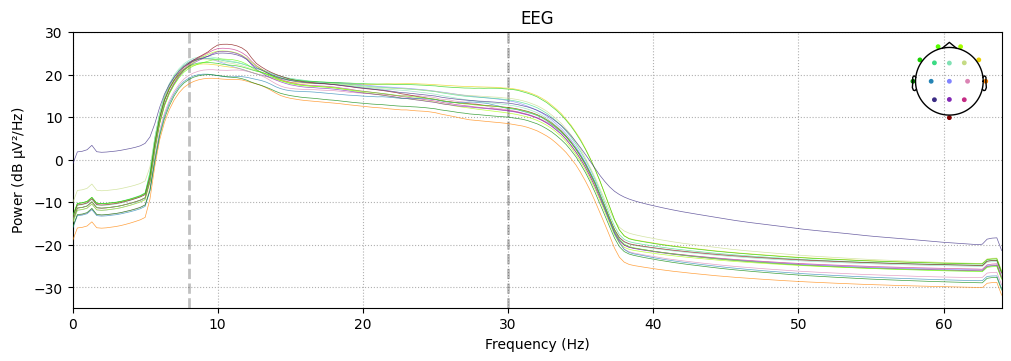

In [17]:
#Plot power 
CleanAlready.compute_psd(fmax=64).plot(picks=CleanAlready.ch_names)
plt.show()

#### Step 5: Epoching and Baseline correction

In [18]:
#Chek if the dataset is done it
print(CleanAlready.baseline)

None


In [19]:
#Epoching
target_classes = [
    
    'elbow flexion',
    'elbow extension'
]

#Select Class from dataset
Selected_epochs = CleanAlready.copy()[target_classes]
Selected_epochs

<EpochsArray | 3600 events (all good), -1 – 1.992 s (baseline off), ~168.8 MiB, data loaded,
 'elbow extension': 1800
 'elbow flexion': 1800>

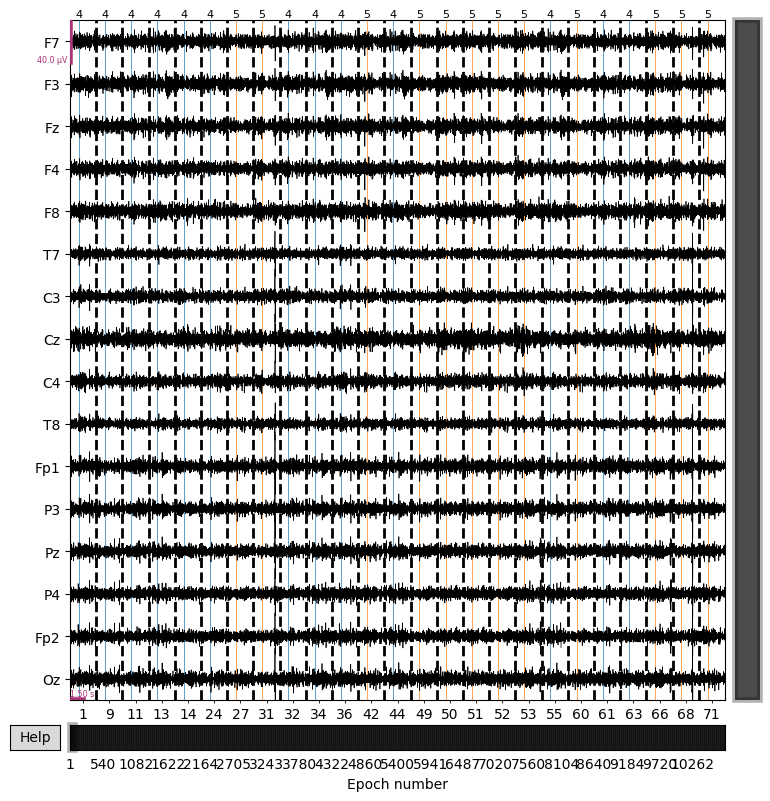

In [20]:
figepoch = Selected_epochs.plot(n_epochs= 25 ,events= True)

In [21]:
# 1 Epoch at trial 0
data = Selected_epochs.get_data()
epoch_0 = data[0]  # shape = (n_channels, n_times)
print(epoch_0.shape)  # เช่น (16, 384)


(16, 384)


In [22]:
# ดูสัญญาณของ Channel หนึ่งใน Epoch นั้น
chn_name = 'C3'
chn_index = Selected_epochs.ch_names.index(chn_name)
signal = data[0, chn_index, :]  # signal ของ C3 ใน epoch 0


In [23]:
#  ดูช่วงเวลาในวินาที
print("Sampling Rate:", Selected_epochs.info['sfreq'])  # เช่น 128 Hz
print("tmin:", Selected_epochs.tmin)
print("tmax:", Selected_epochs.tmax)

# ช่วงเวลา = np.linspace(tmin, tmax, n_times)
time_vector = Selected_epochs.times


Sampling Rate: 128.0
tmin: -1.0
tmax: 1.9921875


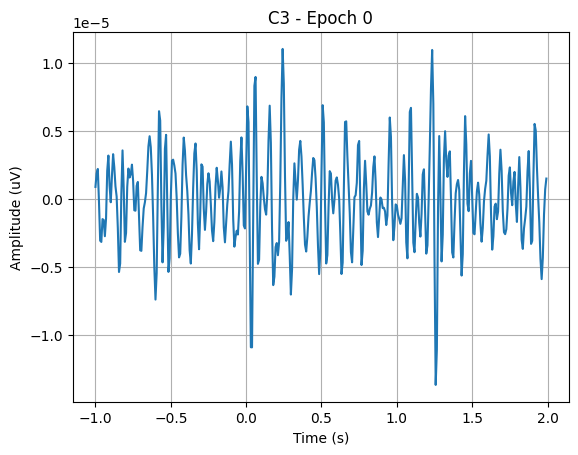

In [24]:
#  Plot ช่องเดียวของ Epoch เดียว
plt.plot(Selected_epochs.times, signal)
plt.title(f"{chn_name} - Epoch 0")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.grid(True)
plt.show()


In [25]:
n_samples = Selected_epochs.get_data().shape[2]
fs = Selected_epochs.info['sfreq']
duration = n_samples / fs
print(f" Duration per Epoch: {duration:.3f} seconds")


 Duration per Epoch: 3.000 seconds


In [26]:
#epoch range
print(Selected_epochs.tmin, Selected_epochs.tmax)

-1.0 1.9921875


In [27]:
#Baseline Correction

#backup
Selectedtuna = Selected_epochs.copy()

Selectedtuna.apply_baseline(baseline=(-0.5, 0))
print("Baseline applied:", Selectedtuna.baseline)
print("Epoch shape:", Selectedtuna.get_data().shape)  # (n_epochs, n_channels, n_times)

Applying baseline correction (mode: mean)
Baseline applied: (-0.5, 0.0)
Epoch shape: (3600, 16, 384)


#### Check Baseline

In [28]:
#Check time per epoch
n_times = Selectedtuna.get_data().shape[2]  # จำนวน sample ต่อ 1 epoch
sfreq = Selectedtuna.info['sfreq']          # sampling rate (Hz)

# คำนวณ duration
duration_sec = n_times / sfreq
print(f"Duration per epoch: {duration_sec:.3f} seconds")


Duration per epoch: 3.000 seconds


In [29]:
# ก่อน
mean_before = np.mean(Selected_epochs.get_data(), axis=2)  # (n_epochs, n_channels)
mean_after = np.mean(Selectedtuna.get_data(), axis=2)

# ดูค่าเฉลี่ยรวมทุก channel ทุก epoch
print(" Mean ก่อน baseline correction:", np.mean(mean_before))
print(" Mean หลัง baseline correction:", np.mean(mean_after))


 Mean ก่อน baseline correction: 6.649241167205094e-10
 Mean หลัง baseline correction: -2.051740355386124e-09


In [30]:
#ต้องการรู้ว่า "Epoch Window" อยู่ช่วงเวลาไหน
print("Epoch window starts at:", epochs.tmin, "seconds")
print("Epoch window ends at:", epochs.tmax, "seconds")


Epoch window starts at: -1.0 seconds
Epoch window ends at: 1.998 seconds


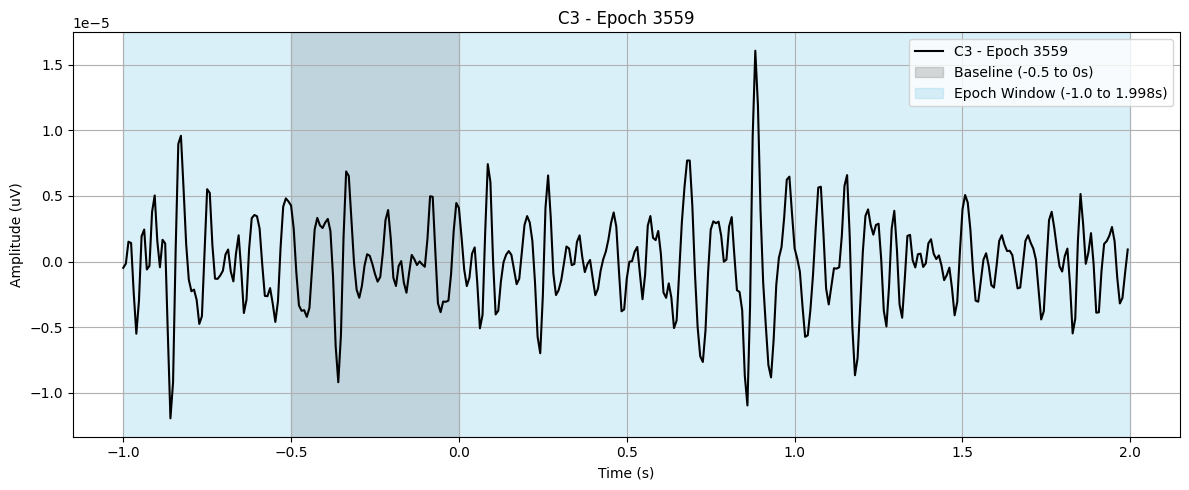

In [31]:
#Plot Epoch พร้อมแถบ Baseline และ Epoch Window
# ดึงข้อมูล
data = Selectedtuna.get_data()         # shape = (n_epochs, n_channels, n_times)
times = Selectedtuna.times             # shape = (n_times,)
fs = Selectedtuna.info['sfreq']        # sampling rate
channel_name = 'C3'
channel_index = Selectedtuna.ch_names.index(channel_name)

# เลือก epoch ที่ต้องการ
epoch_idx = 3559
signal = data[epoch_idx, channel_index, :]  # (n_times,)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(times, signal, label=f'{channel_name} - Epoch {epoch_idx}', color='black')

# Highlight baseline: -0.5 to 0 s
plt.axvspan(-0.5, 0, color='gray', alpha=0.3, label='Baseline (-0.5 to 0s)')

# Highlight epoch window: -1.0 to 1.998
plt.axvspan(-1.0, 1.998, color='skyblue', alpha=0.3, label='Epoch Window (-1.0 to 1.998s)')

# ตกแต่ง
plt.title(f"{channel_name} - Epoch {epoch_idx}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
#Check where cue (Simple index , 0, event_id)
print(Selectedtuna.events[:25])


[[  2001      0      4]
 [ 14001      0      4]
 [ 17001      0      4]
 [ 20001      0      4]
 [ 21501      0      4]
 [ 36501      0      4]
 [ 41001      0      5]
 [ 47001      0      5]
 [ 48501      0      4]
 [ 51501      0      4]
 [ 54501      0      4]
 [ 63501      0      5]
 [ 66501      0      4]
 [ 74001      0      5]
 [ 75501      0      5]
 [ 77001      0      5]
 [ 78501      0      5]
 [ 80001      0      5]
 [ 83001      0      4]
 [ 90501      0      5]
 [ 92001      0      4]
 [ 95001      0      4]
 [ 99501      0      5]
 [102501      0      5]
 [107001      0      5]]


In [33]:
#แปลง 	Sample index เป็นเวลา 
fs = Selectedtuna.info['sfreq']  # เช่น 128 Hz
sample_index = Selectedtuna.events[:, 0]
cue_times_sec = sample_index / fs

print(cue_times_sec[:10])  # cue แรก ๆ เกิดเมื่อไหร่


[ 15.6328125 109.3828125 132.8203125 156.2578125 167.9765625 285.1640625
 320.3203125 367.1953125 378.9140625 402.3515625]


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


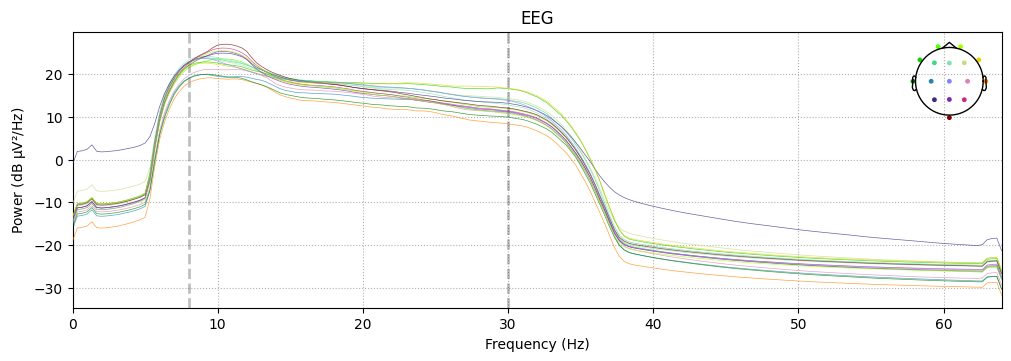

In [47]:
Selectedtuna.compute_psd(fmax=64).plot(picks=Selectedtuna.ch_names)
plt.show()

In [50]:
# ข้อมูลก่อนและหลัง baseline
before = Selected_epochs.get_data()     # (n_epochs, n_channels, n_times)
after = Selectedtuna.get_data()         # หลัง apply_baseline แล้ว

# เปรียบเทียบค่าเฉลี่ยรวม
mean_before = before.mean()
mean_after = after.mean()
delta = mean_after - mean_before

print(f"✅ Mean ก่อน Baseline Correction: {mean_before:.10f}")
print(f"✅ Mean หลัง Baseline Correction: {mean_after:.10f}")
# print(f"🧮 ความแตกต่าง (Δ): {delta:.10f}")


✅ Mean ก่อน Baseline Correction: 0.0000000007
✅ Mean หลัง Baseline Correction: -0.0000000021


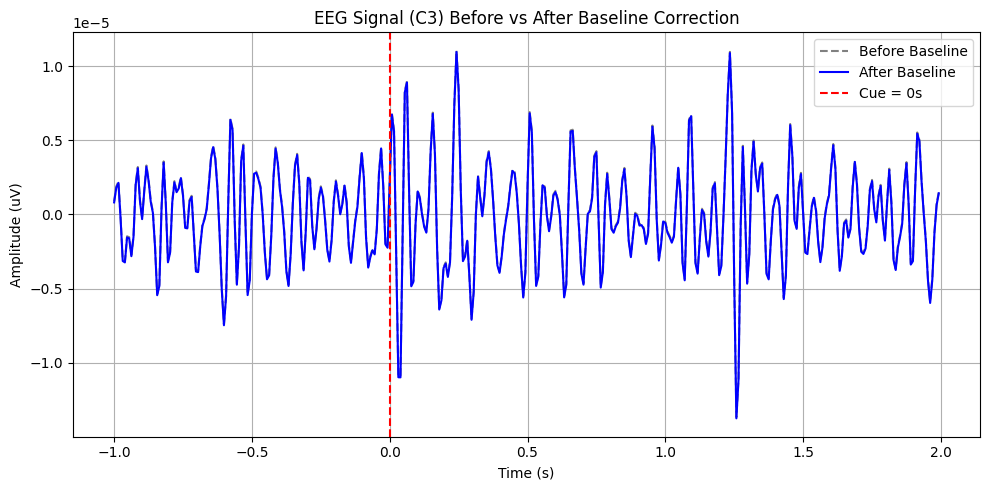

In [118]:
import matplotlib.pyplot as plt

# เลือก channel และ epoch
channel_name = 'C3'
channel_index = Selectedtuna.ch_names.index(channel_name)
epoch_idx = 0
# สัญญาณก่อนและหลัง
sig_b = before[epoch_idx, channel_index, :]
sig_a = after[epoch_idx, channel_index, :]
times = Selectedtuna.times

# Plot
plt.figure(figsize=(10, 5))
plt.plot(times, sig_b, label='Before Baseline', color='gray', linestyle='--')
plt.plot(times, sig_a, label='After Baseline', color='blue')
plt.axvline(0, color='red', linestyle='--', label='Cue = 0s')

plt.title(f"EEG Signal ({channel_name}) Before vs After Baseline Correction")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
#plot ค่าเฉลี่ยของ baseline แต่ละ epoch
mean_baseline = Selectedtuna.copy().crop(tmin=-0.5, tmax=0).get_data().mean(axis=2)
print(mean_baseline.mean())


2.7860852596039214e-25


#### Step 4: Feature Extraction
    - Common Spatial Pattern (CSP)

In [88]:
# Extract data and labels
X = Selectedtuna.get_data()
y = Selectedtuna.events[:, -1]
# Encode label from [1,2,3,4,5,6] → [0,1,2,3,4,5] which model would like to read like this
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded , test_size=0.2, random_state=42)

In [89]:
X.shape #(n_epochs, n_channels, n_times)

(3600, 16, 384)

In [90]:
# 1. Fit CSP using ONLY training data
csp = CSP(n_components=16, reg=None, log=True, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)

# 2. Then transform test set with fitted CSP
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 16 dim * 1e+10  max singular value)
    Estimated rank (data): 14
    data: rank 14 computed from 16 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 16 -> 14
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


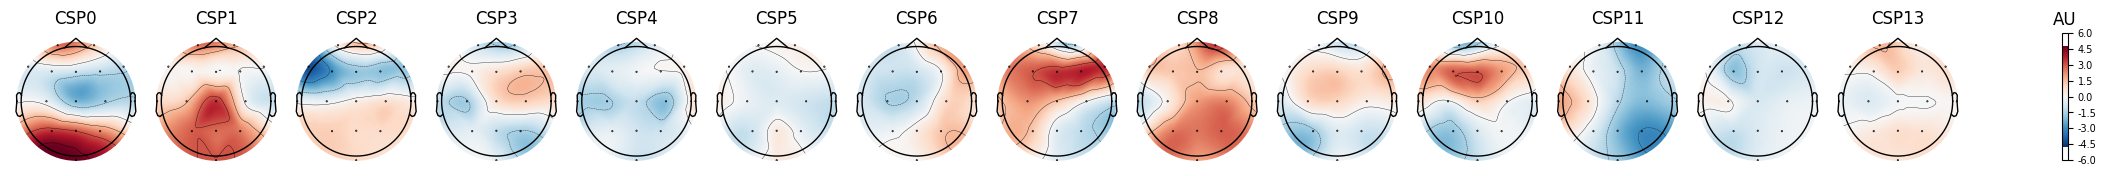

Number of CSP components learned: 14


In [91]:
n = csp.filters_.shape[0]
figx = csp.plot_patterns(info=Selectedtuna.info, components=range(n))

print("Number of CSP components learned:", csp.filters_.shape[0])

In [92]:
print(le.classes_)

[4 5]


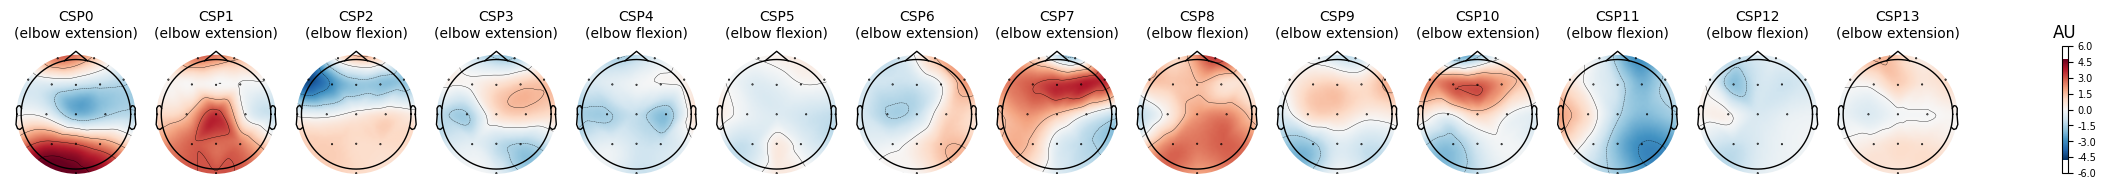

In [101]:
# แยกข้อมูลเป็น class 0 และ class 1
X0 = X_train[y_train == 0]
X1 = X_train[y_train == 1]

# คำนวณ covariance เฉลี่ยของแต่ละ class
cov0 = np.mean([np.cov(x) for x in X0], axis=0)
cov1 = np.mean([np.cov(x) for x in X1], axis=0)

# คำนวณ eigenvalues สำหรับแต่ละ filter
eigenvalues = np.array([
    f.T @ cov0 @ f / (f.T @ cov1 @ f + 1e-10)
    for f in csp.filters_
])

# คำนวณว่าทุก component เน้น class ไหน
dominant_classes = ['elbow extension' if ev > 1.0 else 'elbow flexion' for ev in eigenvalues]

# สร้าง title พร้อม class label
titles = [f'CSP{i}\n({cls})' for i, cls in enumerate(dominant_classes)]

n = csp.filters_.shape[0]
# วาด topomap
fig = csp.plot_patterns(info=Selectedtuna.info, components=range(n), ch_type='eeg', show=False)


# แก้ไขชื่อหัวแต่ละ subplot
for ax, title in zip(fig.axes, titles):
    ax.set_title(title, fontsize=10)

plt.show()


In [102]:
for i, ev in enumerate(eigenvalues):
    print(f'CSP{i}: eigenvalue = {ev:.4f}')

CSP0: eigenvalue = 1.1136
CSP1: eigenvalue = 1.0841
CSP2: eigenvalue = 0.9279
CSP3: eigenvalue = 1.0620
CSP4: eigenvalue = 0.9427
CSP5: eigenvalue = 0.9490
CSP6: eigenvalue = 1.0454
CSP7: eigenvalue = 1.0317
CSP8: eigenvalue = 0.9712
CSP9: eigenvalue = 1.0262
CSP10: eigenvalue = 1.0160
CSP11: eigenvalue = 0.9851
CSP12: eigenvalue = 0.9942
CSP13: eigenvalue = 1.0053


In [103]:
print(eigenvalues)


[1.11356379 1.08413485 0.92792658 1.061978   0.94267233 0.94895007
 1.0453947  1.03165829 0.97120897 1.02623269 1.01597087 0.98512948
 0.9941991  1.00525267]


In [99]:
# ถ้าใช้ LabelEncoder
print(le.classes_)
# หรือถ้าใช้ event_id
print(np.unique(y_train, return_counts=True))


[4 5]
(array([0, 1], dtype=int64), array([1428, 1452], dtype=int64))


In [ ]:
# #วัด n_component ที่ดีที่สุดของแต่ละโมเดล

# # ====== สมมุติข้อมูล ======
# # X_all: (n_trials, n_channels, n_times)
# # y_all: (n_trials,) มีแค่ 0 และ 1
# # >>> ใส่ข้อมูลของคุณเองตรงนี้ <<<
# X_all = X
# y_all = y

# # ====== ใช้ K-Fold แบบ stratified เพื่อ balance class ======
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # ====== กำหนดช่วงของ n_components ที่จะลอง ======
# param_grid = {'csp__n_components': [2, 4, 6, 8, 10, 12, 16]}

# # ====== สร้างและ Tune: LDA ======
# pipe_lda = Pipeline([
#     ('csp', CSP(reg=None, log=True, norm_trace=False)),
#     ('clf', LinearDiscriminantAnalysis())
# ])
# grid_lda = GridSearchCV(pipe_lda, param_grid, cv=cv, scoring='accuracy')
# grid_lda.fit(X_all, y_all)

# # ====== สร้างและ Tune: KNN ======
# pipe_knn = Pipeline([
#     ('csp', CSP(reg=None, log=True, norm_trace=False)),
#     ('clf', KNeighborsClassifier(n_neighbors=5))
# ])
# grid_knn = GridSearchCV(pipe_knn, param_grid, cv=cv, scoring='accuracy')
# grid_knn.fit(X_all, y_all)

# # ====== สร้างและ Tune: SVM ======
# pipe_svm = Pipeline([
#     ('csp', CSP(reg=None, log=True, norm_trace=False)),
#     ('clf', SVC(kernel='linear'))
# ])
# grid_svm = GridSearchCV(pipe_svm, param_grid, cv=cv, scoring='accuracy')
# grid_svm.fit(X_all, y_all)

# # ====== แสดงผลลัพธ์ ======
# print("🔹 Best CSP n_components per model:")
# print("LDA:", grid_lda.best_params_['csp__n_components'], "Accuracy:", grid_lda.best_score_)
# print("KNN:", grid_knn.best_params_['csp__n_components'], "Accuracy:", grid_knn.best_score_)
# print("SVM:", grid_svm.best_params_['csp__n_components'], "Accuracy:", grid_svm.best_score_)


#### Step 5: Classification

#### LDA (Linear Discriminant Analysis)


[TEST] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.53      0.53      0.53       372
  elbow flexion       0.50      0.50      0.50       348

       accuracy                           0.51       720
      macro avg       0.51      0.51      0.51       720
   weighted avg       0.51      0.51      0.51       720

[TEST] Confusion Matrix
จำนวน Test set: 720


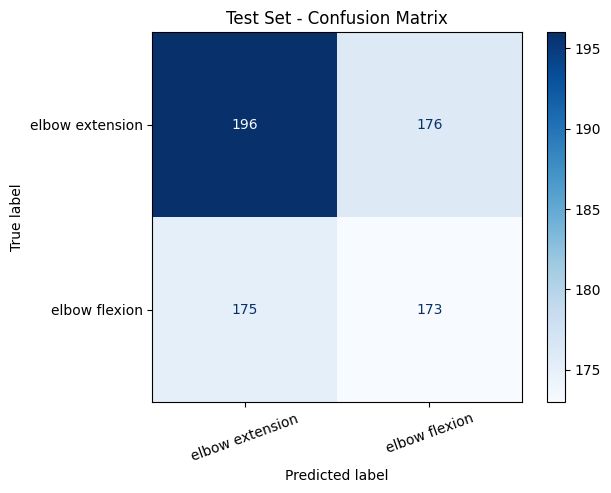


[TRAIN] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.55      0.53      0.54      1428
  elbow flexion       0.55      0.57      0.56      1452

       accuracy                           0.55      2880
      macro avg       0.55      0.55      0.55      2880
   weighted avg       0.55      0.55      0.55      2880

[TRAIN] Confusion Matrix


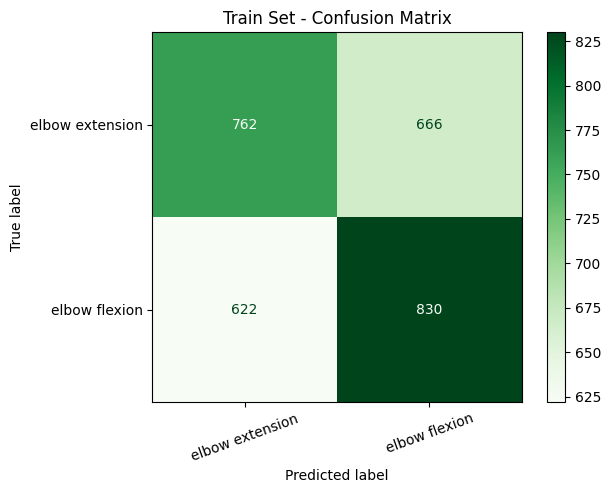

In [ ]:
X = X_train_csp
y = y_train
X_test = X_test_csp

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best LDA
lda_pipeline = Pipeline([('clf', LinearDiscriminantAnalysis())])
lda_params = {'clf__solver': ['lsqr', 'eigen'], 'clf__shrinkage': ['auto', None]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lda_grid = GridSearchCV(lda_pipeline, lda_params, cv=cv, scoring='accuracy', n_jobs=-1)
lda_grid.fit(X_train_csp, y_train)

# Final model
best_lda = lda_grid.best_estimator_
best_lda.fit(X_train_csp, y_train)

# ========= TEST SET RESULTS ========= #
y_test_pred = best_lda.predict(X_test_csp)
y_test_proba = best_lda.predict_proba(X_test_csp)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
total_test = cm_test.sum()
print("จำนวน Test set:", total_test)
# disp = ConfusionMatrixDisplay(cm_test)
disp = ConfusionMatrixDisplay(cm_test, display_labels=class_n)
disp.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()

# ========= TRAIN SET RESULTS ========= #
y_train_pred = best_lda.predict(X_train_csp)
y_train_proba = best_lda.predict_proba(X_train_csp)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
disp.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


#### SVM (Support Vector Machine)


[TEST] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.76      0.78      0.77       372
  elbow flexion       0.76      0.73      0.74       348

       accuracy                           0.76       720
      macro avg       0.76      0.76      0.76       720
   weighted avg       0.76      0.76      0.76       720

[TEST] Confusion Matrix
จำนวน Test set: 720


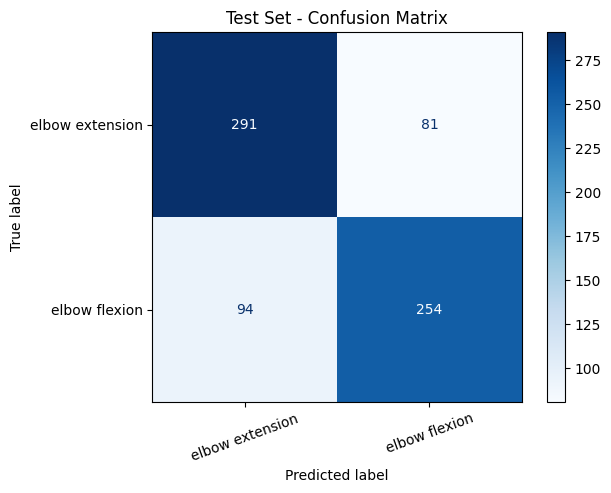


[TRAIN] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.81      0.83      0.82      1428
  elbow flexion       0.83      0.81      0.82      1452

       accuracy                           0.82      2880
      macro avg       0.82      0.82      0.82      2880
   weighted avg       0.82      0.82      0.82      2880

[TRAIN] Confusion Matrix


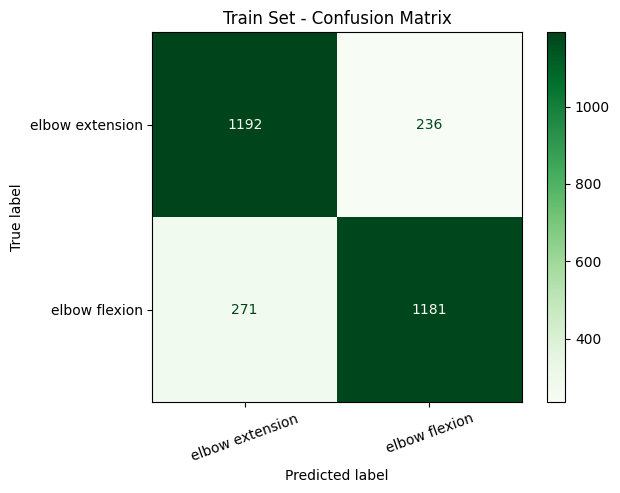

In [ ]:
X = X_train_csp
y = y_train
X_test_final = X_test_csp
n_classes = len(np.unique(y))

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best SVM
svm_pipeline = Pipeline([('clf', SVC(probability=True))])  # ต้องเปิด probability=True เพื่อใช้ ROC AUC
svm_params = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']  # เฉพาะ RBF ใช้ gamma
}
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_csp, y_train)

# Final model
best_svm = svm_grid.best_estimator_
best_svm.fit(X_train_csp, y_train)

# ========= TEST SET =========
y_test_pred = best_svm.predict(X_test_final)
y_test_proba = best_svm.predict_proba(X_test_final)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
total_test = cm_test.sum()
print("จำนวน Test set:", total_test)
dis = ConfusionMatrixDisplay(cm_test,display_labels=class_n)
dis.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


# ========= TRAIN SET =========
y_train_pred = best_svm.predict(X_train_csp)
y_train_proba = best_svm.predict_proba(X_train_csp)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
dis2 = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
dis2.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()

#### KNN (K-Nearest Neighbors)

In [ ]:
# X = X_train_csp
# y = y_train
# X_test = X_test_csp

# n_classes = len(np.unique(y))
# event_id_to_name = {v: B for B, v in Selected_epochs.event_id.items()}
# class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# # GridSearchCV: หา best KNN
# # สร้าง pipeline
# knn_pipeline = Pipeline([('clf', KNeighborsClassifier())])

# # กำหนด grid สำหรับ KNN
# knn_params = {
#     'clf__n_neighbors': [1, 3, 5, 7],
#     'clf__weights': ['uniform', 'distance'],
#     'clf__metric': ['euclidean', 'manhattan']
# }
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=cv, scoring='accuracy', n_jobs=-1)
# knn_grid.fit(X_train_csp, y_train)

# # Final model
# best_knn = knn_grid.best_estimator_
# best_knn.fit(X_train_csp, y_train)

# # ========= TEST SET RESULTS ========= #
# y_test_pred = best_knn.predict(X_test_csp)
# y_test_proba = best_knn.predict_proba(X_test_csp)
# y_test_bin = label_binarize(y_test, classes=range(n_classes))

# print("\n[TEST] Classification Report")
# print(classification_report(y_test, y_test_pred, target_names=class_n))

# print("[TEST] Confusion Matrix")
# cm_test = confusion_matrix(y_test, y_test_pred)
# # disp = ConfusionMatrixDisplay(cm_test)
# disp = ConfusionMatrixDisplay(cm_test, display_labels=class_n)
# disp.plot(cmap="Blues")
# plt.title("Test Set - Confusion Matrix")
# plt.grid(False)
# plt.xticks(rotation=20)
# plt.show()

# # ========= TRAIN SET RESULTS ========= #
# y_train_pred = best_knn.predict(X_train_csp)
# y_train_proba = best_knn.predict_proba(X_train_csp)
# y_train_bin = label_binarize(y_train, classes=range(n_classes))

# print("\n[TRAIN] Classification Report")
# print(classification_report(y_train, y_train_pred, target_names=class_n))

# print("[TRAIN] Confusion Matrix")
# cm_train = confusion_matrix(y_train, y_train_pred)
# disp = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
# disp.plot(cmap="Greens")
# plt.title("Train Set - Confusion Matrix")
# plt.grid(False)
# plt.xticks(rotation=20)
# plt.show()


#### Analysis

In [ ]:
label_counts = Counter(y_all)
for label_id, count in sorted(label_counts.items()):
    label_name = [k for k, v in label_map.items() if v == label_id][0]
    print(f"{label_name:20s}: {count} samples")


elbow extension     : 1800 samples
elbow flexion       : 1800 samples


##### Plot Topomap

In [ ]:
# Check times
Selectedtuna.times
print(f"Start time: {epochs.times[0]:.3f} s")
print(f"End time:   {epochs.times[-1]:.3f} s")

Start time: -1.000 s
End time:   1.998 s


Need more than one channel to make topography for eeg. Disabling interactivity.


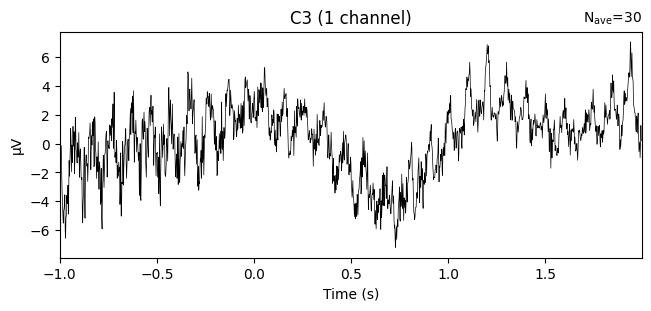

Need more than one channel to make topography for eeg. Disabling interactivity.


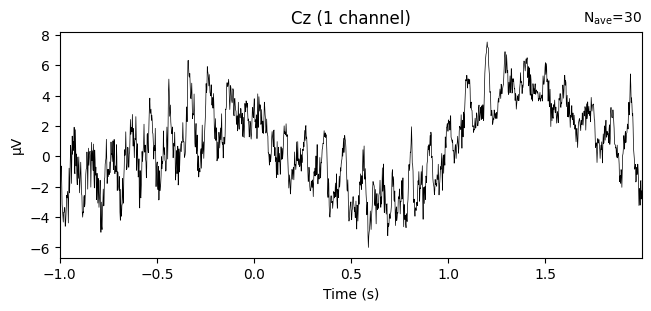

Need more than one channel to make topography for eeg. Disabling interactivity.


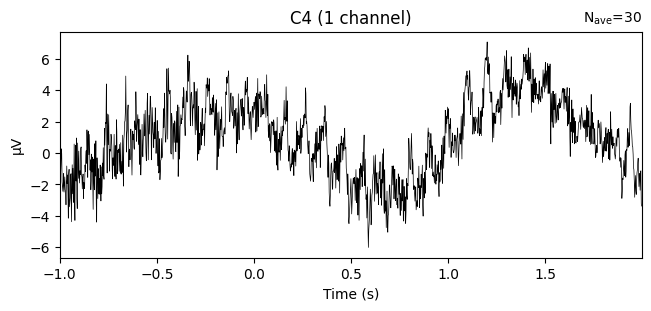

In [ ]:
#Evoked = ค่าเฉลี่ยของ Epochs ที่ตอบสนองต่อเหตุการณ์
#1. ดูลักษณะคลื่นก่อน
evoked = epochs['elbow flexion'].average()
figA = evoked.plot(picks='C3', titles='C3')
figB = evoked.plot(picks='Cz', titles='Cz')
figC = evoked.plot(picks='C4', titles='C4')


In [ ]:
#หา max amplitude
cz_idx = evoked.ch_names.index('Cz')
peak_time = evoked.times[np.argmax(np.abs(evoked.data[cz_idx]))]
print(f"⏱ Cz peak @ {peak_time:.3f} s")

⏱ Cz peak @ 1.202 s


In [107]:
# # สร้าง evoked object สำหรับแต่ละ class และ band
# evoked_flex_mu = Selectedtuna.copy().filter(8, 12)['elbow flexion'].average()
# evoked_flex_beta = Selectedtuna.copy().filter(13, 30)['elbow flexion'].average()
# evoked_exten_mu = Selectedtuna.copy().filter(8, 12)['elbow extension'].average()
# evoked_exten_beta = Selectedtuna.copy().filter(13, 30)['elbow extension'].average()

# # Plot topomap ณ เวลา 1.0 วินาที (หรือเวลาที่คุณต้องการดู ERD)
# f1=evoked_flex_mu.plot_topomap(ch_type='eeg', time_unit='s')
# f2=evoked_flex_beta.plot_topomap(ch_type='eeg', time_unit='s')
# f3=evoked_exten_mu.plot_topomap(ch_type='eeg', time_unit='s')
# f4=evoked_exten_beta.plot_topomap(ch_type='eeg', time_unit='s')


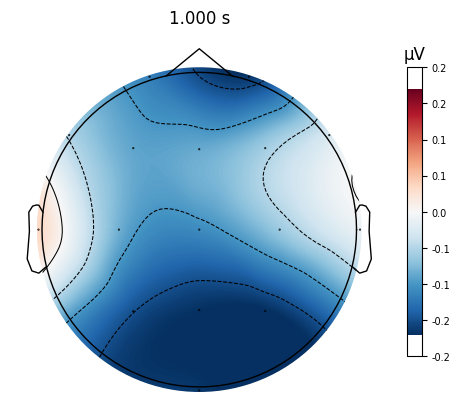

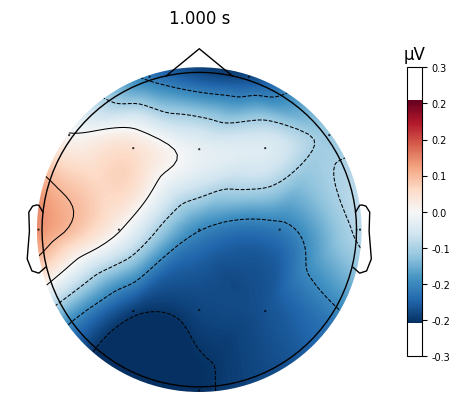

In [112]:

# --- แยกตาม condition ---
epochs_flex = Selectedtuna['elbow flexion']
epochs_exten = Selectedtuna['elbow extension']

# --- คำนวณ Evoked เฉลี่ยสำหรับแต่ละ condition ---
evoked_flex = epochs_flex.average()
evoked_exten = epochs_exten.average()

# --- ตั้งค่าเวลาในช่วงที่คุณต้องการ plot (s) ---
# เช่น ช่วงเวลาที่มี motor imagery อยู่ราว ๆ 0.5–1.5s หลัง cue
times_to_plot = [1.0]  # หน่วยวินาที

# --- วาด 3D scalp topomap สำหรับ Flexion ---
evoked_flex.plot_topomap(
    times=times_to_plot,
    ch_type='eeg',
    sphere=0.1,         # ทำให้แสดงเป็นแบบกลม (3D-like)
    size=3,             # ขนาดกราฟใหญ่ขึ้น
    time_unit='s',
    # title='3D Topomap - Flexion'
)

# --- วาด 3D scalp topomap สำหรับ Extension ---
evoked_exten.plot_topomap(
    times=times_to_plot,
    ch_type='eeg',
    sphere=0.1,
    size=3,
    time_unit='s',
    # title='3D Topomap - Extension'
)

plt.show()


##### Plot Mu/Beta

4.2.1 การเปลี่ยนแปลงพลังงานในย่าน Mu และ Beta ของสัญญาณ EEG:

- ช่วง Mu (8–12 Hz) และ ช่วง Beta (13–30 Hz) เปลี่ยนแปลงอย่างไรระหว่างการ Flex / Extend

- ใช้การเปรียบเทียบค่า Power ระหว่างช่วง baseline กับช่วง task

- ใช้ ERD/ERS (Event-Related Desynchronization/Synchronization) เป็นดัชนี

In [ ]:
Selectedtuna.event_id

{'elbow extension': 4, 'elbow flexion': 5}

In [ ]:
# # สมมติว่า filtered_epochs มีข้อมูลที่ preprocess แล้ว (เช่น baseline corrected, downsample แล้ว)
# epochs = Selectedtuna.copy()

# # ตั้งค่า
# channel_names = ['C3', 'Cz', 'C4']
# mu_band = (8, 12)
# beta_band = (13, 30)
# baseline_t = (-0.5, 0)  # วินาทีก่อน stimulus
# task_t = (0.1, 2)     # วินาทีหลัง stimulus

# # สร้างฟังก์ชันคำนวณ power
# def compute_band_power(epochs, band, picks):
#     band_epochs = epochs.copy().filter(band[0], band[1], fir_design='firwin')
#     data = band_epochs.get_data(picks=picks)  # shape: (n_epochs, n_channels, n_times)
#     power = np.abs(hilbert(data)) ** 2
#     return power

# # คำนวณ ERD/ERS
# fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# for idx, (band, title) in enumerate(zip([mu_band, beta_band], ['Mu (8-12Hz)', 'Beta (13-30Hz)'])):
#     power = compute_band_power(epochs, band, picks=channel_names)
#     times = epochs.times

#     # หาตำแหน่งช่วงเวลา
#     baseline_idx = np.where((times >= baseline_t[0]) & (times <= baseline_t[1]))[0]
#     task_idx = np.where((times >= task_t[0]) & (times <= task_t[1]))[0]

#     baseline_power = power[:, :, baseline_idx].mean(axis=2)
#     task_power = power[:, :, task_idx].mean(axis=2)

#     # คำนวณ ERD/ERS (%)
#     erd = ((task_power - baseline_power) / baseline_power) * 100
#     erd_mean = erd.mean(axis=0)

#     axs[idx].bar(channel_names, erd_mean)
#     axs[idx].set_title(f'ERD/ERS in {title}')
#     axs[idx].set_ylabel('ERD/ERS (%)')
#     axs[idx].axhline(0, color='black', linestyle='--')

# plt.tight_layout()
# plt.show()


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.3s
[Parallel(n_job

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.4s
[Parallel(n_job

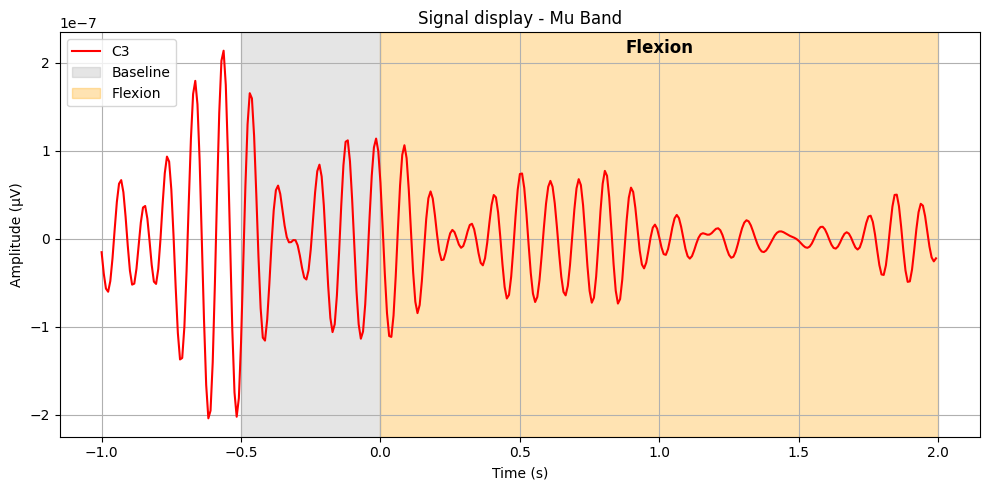

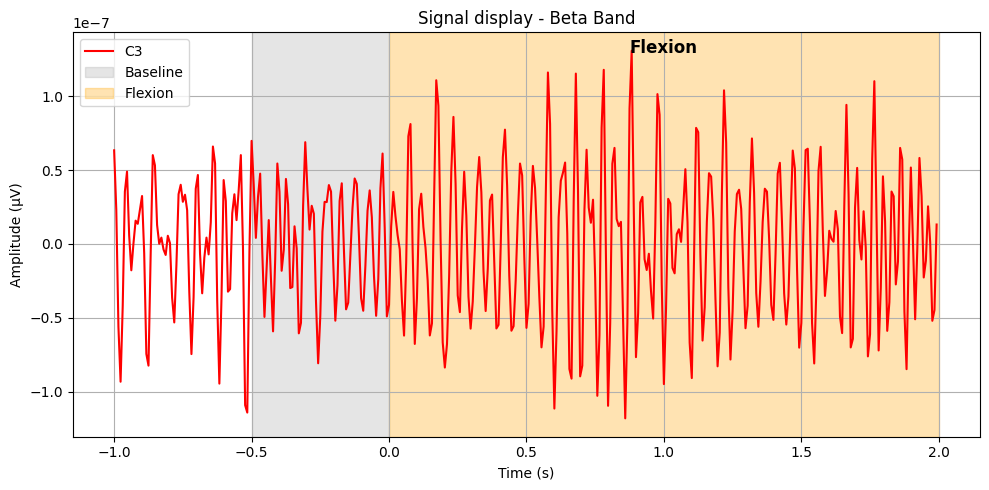

In [123]:

# กำหนด band ที่ต้องการ
mu_band = (8, 12)
beta_band = (13, 30)

# กรองเฉพาะย่านความถี่ Mu และ Beta
epochs_mu = Selectedtuna.copy().filter(mu_band[0], mu_band[1], fir_design='firwin')
epochs_beta = Selectedtuna.copy().filter(beta_band[0], beta_band[1], fir_design='firwin')

# แยกเฉพาะ class 'elbow flexion'
epochs_flex_mu = epochs_mu['elbow flexion']
epochs_flex_beta = epochs_beta['elbow flexion']

# สร้าง evoked object โดยเฉลี่ย (average across epochs)
evoked_flex_mu = epochs_flex_mu.average()
evoked_flex_beta = epochs_flex_beta.average()

def plot_evoked_custom_focus(evoked, band_name, picks=['C3'],
                              baseline=(-0.5, 0.0), flexion=(0.0, 2.0), time_window=(-1.0, 2.0)):

    # Map สีให้แต่ละ channel
    colors = ['red', 'green', 'blue']

    # เลือกเฉพาะช่วงเวลาที่ต้องการ
    times = evoked.times
    time_mask = (times >= time_window[0]) & (times <= time_window[1])
    times_focus = times[time_mask]

    # เลือกเฉพาะ channel ที่ต้องการ
    ch_indices = [evoked.ch_names.index(ch) for ch in picks]
    data = evoked.data[ch_indices][:, time_mask]  # shape = (3, selected_times)

    # Plot
    plt.figure(figsize=(10, 5))
    for i, ch_name in enumerate(picks):
        plt.plot(times_focus, data[i], label=ch_name, color=colors[i])

    # Highlight baseline (gray) และ Flexion (orange)
    plt.axvspan(baseline[0], baseline[1], color='gray', alpha=0.2, label='Baseline')
    plt.axvspan(flexion[0], flexion[1], color='orange', alpha=0.3, label='Flexion')

    plt.text((flexion[0]+flexion[1])/2, plt.ylim()[1]*0.9, 'Flexion', ha='center', fontsize=12, fontweight='bold')
    plt.title(f'Signal display - {band_name} Band')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# เรียกใช้งาน
plot_evoked_custom_focus(evoked_flex_mu, 'Mu')
plot_evoked_custom_focus(evoked_flex_beta, 'Beta')

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.3s
[Parallel(n_job

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.4s
[Parallel(n_job

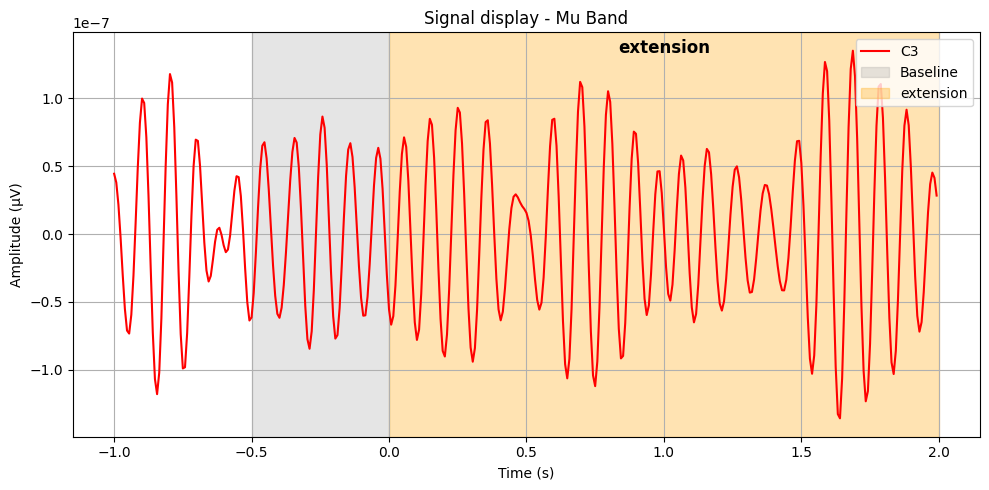

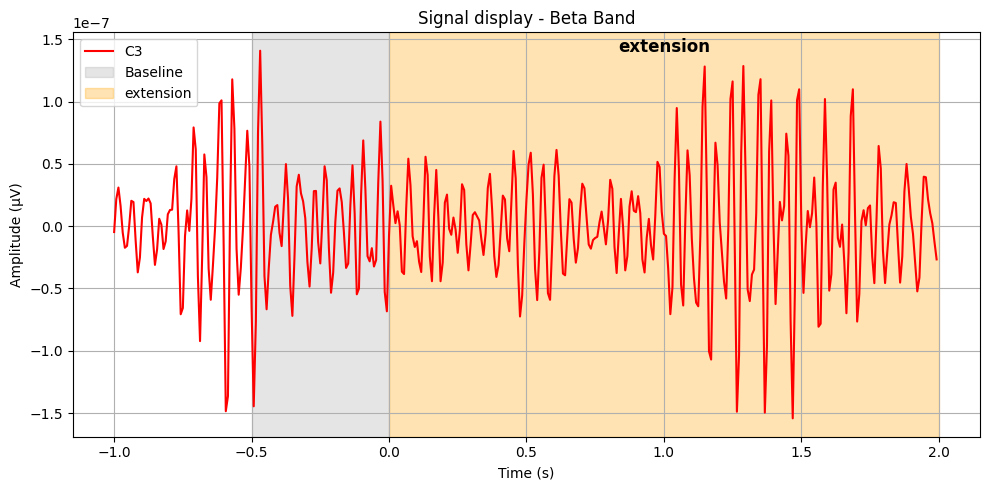

In [122]:

# กำหนด band ที่ต้องการ
mu_band = (8, 12)
beta_band = (13, 30)

# กรองเฉพาะย่านความถี่ Mu และ Beta
epochs_mu = Selectedtuna.copy().filter(mu_band[0], mu_band[1], fir_design='firwin')
epochs_beta = Selectedtuna.copy().filter(beta_band[0], beta_band[1], fir_design='firwin')

# แยกเฉพาะ class 'elbow flexion'
epochs_flex_mu = epochs_mu['elbow extension']
epochs_flex_beta = epochs_beta['elbow extension']

# สร้าง evoked object โดยเฉลี่ย (average across epochs)
evoked_flex_mu = epochs_flex_mu.average()
evoked_flex_beta = epochs_flex_beta.average()

def plot_evoked_custom_focus(evoked, band_name, picks=['C3'],
                              baseline=(-0.5, 0.0), flexion=(0.0, 2.0), time_window=(-1.0, 2.0)):

    # Map สีให้แต่ละ channel
    colors = ['red', 'green', 'blue']

    # เลือกเฉพาะช่วงเวลาที่ต้องการ
    times = evoked.times
    time_mask = (times >= time_window[0]) & (times <= time_window[1])
    times_focus = times[time_mask]

    # เลือกเฉพาะ channel ที่ต้องการ
    ch_indices = [evoked.ch_names.index(ch) for ch in picks]
    data = evoked.data[ch_indices][:, time_mask]  # shape = (3, selected_times)

    # Plot
    plt.figure(figsize=(10, 5))
    for i, ch_name in enumerate(picks):
        plt.plot(times_focus, data[i], label=ch_name, color=colors[i])

    # Highlight baseline (gray) และ Flexion (orange)
    plt.axvspan(baseline[0], baseline[1], color='gray', alpha=0.2, label='Baseline')
    plt.axvspan(flexion[0], flexion[1], color='orange', alpha=0.3, label='extension')

    plt.text((flexion[0]+flexion[1])/2, plt.ylim()[1]*0.9, 'extension', ha='center', fontsize=12, fontweight='bold')
    plt.title(f'Signal display - {band_name} Band')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# เรียกใช้งาน
plot_evoked_custom_focus(evoked_flex_mu, 'Mu')
plot_evoked_custom_focus(evoked_flex_beta, 'Beta')

In [115]:
# # เลือก epoch ที่ต้องการดู (เช่น epoch แรก)
# epoch_index = 0

# # สร้าง subset: ช่องที่ต้องการและ epoch ที่ต้องการ
# picks = ['C3', 'Cz', 'C4']
# ch_indices = [Selectedtuna.ch_names.index(ch) for ch in picks]

# # สร้าง RawArray เพื่อ plot แบบ evoked ได้
# import mne
# import numpy as np

# # ดึง data
# epoch_data = Selectedtuna.get_data()[epoch_index, ch_indices, :]  # shape: (3, n_times)
# info = Selectedtuna.copy().pick(picks=picks).info
# times = Selectedtuna.times

# # สร้าง EvokedArray (ชื่อเหมือน ERP)
# evoked_epoch = mne.EvokedArray(epoch_data, info, tmin=Selectedtuna.tmin)

# # แสดงกราฟ
# evoked_epoch.plot(picks=picks, spatial_colors=True, time_unit='s', titles='Single Flexion Trial')


In [116]:
# Fig = Selectedtuna.plot(picks = ['C3','Cz','C4'], n_epochs= 8, events = True)

In [120]:
import mne
import plotly.graph_objects as go
import numpy as np

# Step 1: เตรียมข้อมูล
evoked = Selectedtuna['elbow flexion'].average()  # หรือ extension ก็ได้
times = 1.0  # วินาที
data = evoked.copy().crop(tmin=times, tmax=times).data[:, 0]  # Voltage ที่เวลาเดียว

# Step 2: ดึงตำแหน่ง sensor (xyz)
montage = evoked.get_montage()
pos = montage.get_positions()['ch_pos']
ch_names = evoked.info['ch_names']
xyz = np.array([pos[ch] for ch in ch_names])

# Step 3: plot with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2],
    mode='markers+text',
    marker=dict(
        size=7,
        color=data,  # ใช้แรงดันเป็นสี
        colorscale='RdBu',
        colorbar=dict(title='µV'),
        showscale=True
    ),
    text=ch_names,
    hoverinfo='text'
))

fig.update_layout(
    title=f"3D Scalp Activity at {times:.2f} s",
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    )
)

fig.show()


In [121]:
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator, apply_inverse

subjects_dir = mne.datasets.fetch_fsaverage(verbose=True)
subject = 'fsaverage'

# กำหนด montage (เช่น standard_1020)
evoked.set_montage('standard_1020')

# สร้าง source space
src = mne.setup_source_space(subject, spacing='oct6', subjects_dir=subjects_dir, add_dist=False)

# สร้าง BEM model
model = mne.make_bem_model(subject=subject, ico=4, conductivity=(0.3,), subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

# สร้าง forward solution
fwd = mne.make_forward_solution(evoked.info, trans='fsaverage', src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=1)

# สร้าง inverse operator
inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov=None)

snr = 3.0
lambda2 = 1.0 / snr ** 2
stc_flex = apply_inverse(evoked_flex, inverse_operator, lambda2, method='dSPM')
stc_exten = apply_inverse(evoked_exten, inverse_operator, lambda2, method='dSPM')

# Flexion
brain_flex = stc_flex.plot(subject=subject, subjects_dir=subjects_dir,
                           initial_time=1.0, surface='inflated', hemi='both',
                           time_unit='s', title='Flexion')

# Extension
brain_exten = stc_exten.plot(subject=subject, subjects_dir=subjects_dir,
                             initial_time=1.0, surface='inflated', hemi='both',
                             time_unit='s', title='Extension')


Using default location ~/mne_data for montage coregistration...
Creating C:\Users\HP\mne_data
Attempting to create new mne-python configuration file:
C:\Users\HP\.mne\mne-python.json
179 files missing from root.txt in C:\Users\HP\mne_data\MNE-fsaverage-data


100%|########################################| 196M/196M [00:00<00:00, 195GB/s]


Extracting missing files
Successfully extracted 179 files
10 files missing from bem.txt in C:\Users\HP\mne_data\MNE-fsaverage-data\fsaverage


100%|########################################| 239M/239M [00:00<00:00, 238GB/s]


Extracting missing files
Successfully extracted 10 files


OSError: Could not find the LH surface C:\Users\HP\mne_data\MNE-fsaverage-data\fsaverage\fsaverage\surf\lh.white